In [26]:
import torch
import torch.nn.functional as F
import os
import os.path
import shutil
import numpy as np
import soundfile as sf
import librosa as lr
import librosa.display as lrd
import matplotlib.pyplot as plt

from pathlib import PurePath
from torch import nn
from torch.utils.data import DataLoader, random_split
from asteroid.data import TimitDataset
from asteroid.data.utils import CachedWavSet, RandomMixtureSet, FixedMixtureSet
from asteroid_filterbanks.transforms import mag
from tqdm import tqdm
from einops import rearrange

from torch import optim
from pytorch_lightning import Trainer, seed_everything, loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from asteroid_filterbanks import make_enc_dec
from asteroid_filterbanks.transforms import mag
from asteroid.engine import System, UNetGAN
from asteroid.utils import unsqueeze_to_3d
from asteroid.utils.notebook_utils import show_wav
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_mse

from asteroid import DCUNet, DCCRNet, DPRNNTasNet, ConvTasNet, RegressionFCNN, WaveUNet, Demucs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants and utils

In [2]:
BATCH_SIZE       = 32     # could be more on cluster, test if larger one work
SAMPLE_RATE      = 8000   # as agreed upon
CROP_LEN         = 16384  # trying to train UNetGAN, so let's focus on that first
SEED             = 42     # magic number :)    

# directory with train noises (n116-n120)
DRONE_NOISE_DIR = '../../../datasets/noises-train-drones'
# fixed SNRs for validation set
TRAIN_SNRS = [-25, -20, -15, -10, -5]

def sisdr_loss_wrapper(est_target, target):
    return singlesrc_neg_sisdr(est_target.squeeze(1), target).mean()

def train_val_split(ds, val_fraction=0.1, random_seed=SEED):
    assert val_fraction > 0 and val_fraction < 0.5
    len_train = int(len(ds) * (1 - val_fraction))
    len_val = len(ds) - len_train
    return random_split(ds, [len_train, len_val], generator=torch.Generator().manual_seed(random_seed))

def get_opt_and_sched(model, lr, lr_patience):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=lr_patience)
    return optimizer, scheduler

## Prepare the data

### Download and resample TIMIT dataset 

In [3]:
TIMIT_DIR = PurePath('../../../datasets/TIMIT')
TIMIT_DIR_8kHZ = PurePath('/import/vision-eddydata/dm005_tmp/TIMIT_8kHZ')

### Load and split the data

In [4]:
%%time
# This is for training with on-the-fly random noise mixture with random SNR from the range.
# Is expected to produce a more robust result: checking this now on EECS server

# Reproducibility - fix all random seeds
seed_everything(SEED)

# Load noises, resample and save into the memory
noises = CachedWavSet(DRONE_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

# Load clean data and split it into train and val
timit = TimitDataset(TIMIT_DIR_8kHZ, subset='train', sample_rate=SAMPLE_RATE, with_path=False)
timit_train, timit_val = train_val_split(timit, val_fraction=0.1, random_seed=SEED)

# Training data mixes crops randomly on the fly with random SNR in range (effectively infinite training data)
# `repeat_factor=20` means that the dataset contains 20 copies of itself - it is the easiest way to make the epoch longer
timit_train = RandomMixtureSet(timit_train, noises, random_seed=SEED, snr_range=(-25, -5),
                               crop_length=CROP_LEN, repeat_factor=10)

# Validation data is fixed (for stability): mix every clean clip with all the noises in the folder
# Argument `mixtures_per_clean` regulates with how many different noise files each clean file will be mixed
timit_val = FixedMixtureSet(timit_val, noises, snrs=TRAIN_SNRS, random_seed=SEED,
                            mixtures_per_clean=5, crop_length=CROP_LEN)

Precaching audio: 100%|██████████| 5/5 [00:28<00:00,  5.73s/it]


CPU times: user 26.6 s, sys: 92.3 ms, total: 26.7 s
Wall time: 29.5 s


In [5]:
# Reproducibility - fix all random seeds
# seed_everything(SEED)

# # Load noises, resample and save into the memory
# noises = CachedWavSet(DRONE_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

# timit = TimitDataset(TIMIT_DIR_8kHZ, subset='train', sample_rate=SAMPLE_RATE, with_path=False)
# timit_mix = FixedMixtureSet(timit, noises, snrs=TRAIN_SNRS, random_seed=SEED,
#                             mixtures_per_clean=5, crop_length=CROP_LEN)

# timit_train, timit_val = train_val_split(timit_mix, val_fraction=0.1, random_seed=SEED)

In [6]:
NUM_WORKERS = 5
train_loader = DataLoader(timit_train, shuffle=True, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS, drop_last=True)
val_loader = DataLoader(timit_val, batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS, drop_last=True)

## Set up the model, optimizer and scheduler

In [7]:
LR = 1e-3
REDUCE_LR_PATIENCE = 3
EARLY_STOP_PATIENCE = 5
MAX_EPOCHS = 100

# the model here should be constructed in the script accordingly to the passed config (including the model type)
# most of the models accept `sample_rate` parameter for encoders, which is important (default is 16000, override)
#model = DCUNet("DCUNet-20", fix_length_mode="trim", sample_rate=SAMPLE_RATE)
#model = DCCRNet("DCCRN-CL", sample_rate=SAMPLE_RATE)
unetgan = UNetGAN()
loss = F.mse_loss

# Glorot initialization of the model's parameters (important, mentioned in the paper)
# lrelu_gain = nn.init.calculate_gain('leaky_relu', 0.01)
# def init_weights(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.xavier_normal_(m.weight, gain=lrelu_gain)
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)
    
# model = model.apply(init_weights)

## Train the generator with MSE loss separately first

In [10]:
class FixDimSystem(System):
    def common_step(self, batch, batch_nb, train=True):
        inputs, targets = batch
        inputs = unsqueeze_to_3d(inputs)
        targets = unsqueeze_to_3d(targets)
        
        est_targets = self(inputs)
        loss = self.loss_func(est_targets, targets)
        return loss

In [11]:
optimizer, scheduler = get_opt_and_sched(unetgan.generator, LR, REDUCE_LR_PATIENCE)
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)
checkpoint = ModelCheckpoint(
    filename='{epoch:02d}-{val_loss:.2f}',
    monitor="val_loss",
    mode="min",
    save_top_k=5
)

# Probably we also need to subclass `System`, in order to log the target metrics on the validation set (PESQ/STOI)
system = FixDimSystem(unetgan.generator, optimizer, loss, train_loader, val_loader, scheduler)

In [16]:
system = FixDimSystem.load_from_checkpoint(
    '../../../workspace/logs/UNetGAN-generator-pretrain/version_1/checkpoints/epoch=44-val_loss=0.00.ckpt',
    model=unetgan.generator,
    optimizer=optimizer, loss_func=loss, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler
    )

torch.Size([16384])


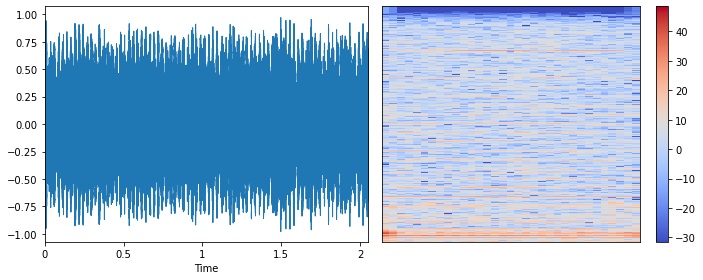

In [27]:
mix, clean = timit_val[0]
print(mix.shape)
show_wav(mix)

In [29]:
enh = unetgan.generator(unsqueeze_to_3d(mix))

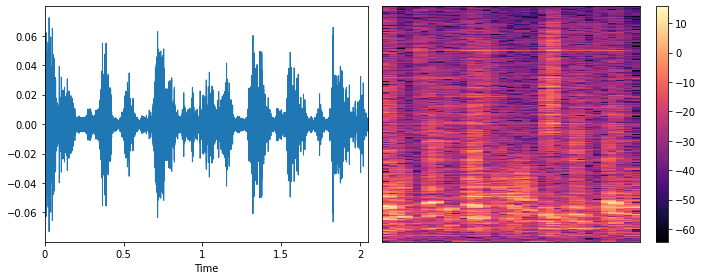

In [31]:
show_wav(enh.flatten())

In [33]:
# log dir and model name are also part of the config, of course
LOG_DIR = '../../../workspace/logs'
logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='UNetGAN-generator-pretrain', version=1)

# choose the proper accelerator for JADE, probably `ddp` (also, `auto_select_gpus=True` might be useful)
trainer = Trainer(max_epochs=MAX_EPOCHS, gpus=[0, 3], accelerator='dp',
                  logger=logger, callbacks=[early_stopping, checkpoint], deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [22]:
trainer.fit(system)


  | Name  | Type             | Params
-------------------------------------------
0 | model | UNetGANGenerator | 9.6 M 
-------------------------------------------
9.6 M     Trainable params
0         Non-trainable params
9.6 M     Total params


/homes/dm005/conda_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1

In [37]:
logger2 = pl_loggers.TensorBoardLogger(LOG_DIR, name='UNetGAN-pretrained-gen', version=2)
trainer2 = Trainer(max_epochs=100, gpus=[0, 2, 3], accelerator='dp',
                   resume_from_checkpoint='../../../workspace/logs/UNetGAN-pretrained-gen/version_1/checkpoints/epoch=25-val_loss=0.00.ckpt',
                   logger=logger2, callbacks=[checkpoint], deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


## Enhance further using GAN training

In [ ]:
trainer2.fit(unetgan, train_loader, val_loader)


  | Name          | Type                 | Params
-------------------------------------------------------
0 | generator     | UNetGANGenerator     | 9.6 M 
1 | discriminator | UNetGANDiscriminator | 621 K 
-------------------------------------------------------
621 K     Trainable params
9.6 M     Non-trainable params
10.3 M    Total params


/homes/dm005/conda_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
